In [10]:
import paramiko
import getpass

host = "158.251.88.197"
port = 22
username = "iaraya"
password = getpass.getpass()

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(host, port, username, password)

 ········


### Loading the instance

In [11]:
from bsg import load_BRinstance,load_BRKGAinstance, load_LargeInstance
from mclp import generate_candidate_solution
import numpy as np

#L,W,H,boxes,id2box = load_BRinstance(filename="BR8.txt",inst=4, nbox=1)
L,W,H,boxes,id2box = load_BRKGAinstance(filename="../benchs/class7/200.txt",inst=1, nbox=1)
#L,W,H,boxes,id2box = load_LargeInstance(filename="../benchs/Data_large/L_2000/L_2000_2.txt", nbox=1, rot_allowed=True)
_boxes=boxes.copy()

r_param = 1.5 
total_test = 100

### Estimating adjusted vols (optional)

In [12]:
boxes=_boxes.copy()

nsols = 10;
bins = []
for _ in range(nsols):
    bin  = generate_candidate_solution(ssh,L,W,H,boxes,id2box, r_param=r_param, bsg_time=1)
    bins = [*bins,*bin[:-5]]
    boxes=_boxes.copy()
    
from sklearn.linear_model import LinearRegression
#10x1 + 5x2 +7x3 = 1
#7x3 + 1x7 = 1
#7x3 + 14x1 = 1 
#...

X = []; y=[]
for bin in bins:
    x = np.zeros(len(_boxes))
    i=0
    for box in _boxes:
        if box in bin.boxes:
            x[i]=bin.boxes[box]
        i+=1
    X.append(x)
    y.append(1.0)

reg = LinearRegression(fit_intercept=False).fit(X, y)

i = 0

for box in _boxes:
    vol = box.vol/(L*W*H) 
    if reg.coef_[i] < vol: box.adj_vol=vol
    else: box.adj_vol=reg.coef_[i]
    i+=1
    
#print( reg.coef_)

Initial Solution: 30
Initial Solution: 29
Initial Solution: 30
Initial Solution: 29
Initial Solution: 29
Initial Solution: 31
Initial Solution: 30
Initial Solution: 30
Initial Solution: 30
Initial Solution: 30


In [13]:
import copy as cp

i=0
precomputed_vols = reg.coef_
vols = cp.deepcopy(reg.coef_)
for box in _boxes:
    vol = box.vol/(L*W*H) 
    vols[i] = vol
    if precomputed_vols[i] < vol: 
        precomputed_vols[i]=vol
    box.adj_vol=precomputed_vols[i]
    i+=1    

(-0.043321149450164895, 0.9131816384534627)

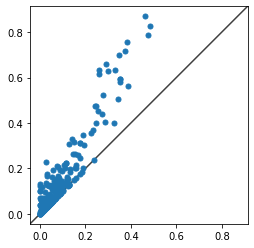

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(vols, precomputed_vols, s=25,cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

### Solver

In [15]:
from mclp import get_random_bin

def get_adjusted_vol(boxes):
    vol=0.0
    for box in boxes:
        vol += box.adj_vol*boxes[box]
    return vol

def get_vol(boxes):
    vol=0.0
    for box in boxes:
        vol += box.vol*boxes[box]
    return vol
      
def adjusted_swap(solution, n=2,  max_vol_accept=1.0, tolerance=0.1, verbose=True):
    bin_A = get_random_bin(s = solution)
    bin_B = get_random_bin(s = solution, b = bin_A)
    
    iniA = bin_A.adj_vol
    iniB = bin_B.adj_vol
    var_ini = (bin_A.adj_vol-1.0)**2 + (bin_B.adj_vol-1.0)**2
    
    nA = int(random.randint(1, n))
    boxes_A = bin_A.pop_random_boxes(nA)
    adjvolA = get_adjusted_vol(boxes_A)
    
    nB = int(random.randint(0, n))
    boxes_B = bin_B.pop_random_boxes(nB)
    adjvolB = get_adjusted_vol(boxes_B)
    
    r = tolerance*random.random()
    accepted = False
    
    if adjvolA > adjvolB and bin_B.adj_vol + adjvolA <= max_vol_accept + r:
        accepted = True
    elif adjvolB > adjvolA and  bin_A.adj_vol + adjvolB <= max_vol_accept + r:
        accepted = True
    
    if accepted:
        bin_A.insert_boxes(boxes_B)
        bin_B.insert_boxes(boxes_A)
    else: return -10
        
    var_final = (bin_A.adj_vol-1.0)**2 + (bin_B.adj_vol-1.0)**2
        
    var_diff = var_final - var_ini
    #if var_diff>0:
    #    print(iniA, bin_A.adj_vol)
    #    print(iniB, bin_B.adj_vol)
    
    return var_diff

In [16]:
boxes=_boxes.copy()
init_solution=generate_candidate_solution(ssh,L,W,H,boxes,id2box, r_param=r_param)

Initial Solution: 29


In [17]:
import copy as cp
for bin in init_solution:
    bin.set_adj_vol(get_adjusted_vol(bin.boxes))
    bin.set_vol(get_vol(bin.boxes))
# Bins adjusted volumes
print("adjusted volumes of each bin:",[get_adjusted_vol(bin.boxes) for bin in init_solution])
print([get_vol(bin.boxes)/(L*W*H) for bin in init_solution])
best_solution = cp.deepcopy(init_solution)

adjusted volumes of each bin: [0.985929573548675, 1.1486290046905288, 1.2927663604361932, 1.1811037079291875, 1.0434222048480617, 0.795411068827549, 1.2166517740988927, 1.0965504519763056, 1.3724409550898753, 1.0358542419886316, 1.3579238021975093, 1.1400463629837743, 1.0454122106599857, 1.1588729109382863, 1.3403043604273868, 1.6785551007276494, 1.3316314933668711, 1.1001697306153786, 0.887195960636113, 1.0722404216622454, 1.1899425708068678, 0.7701892702563866, 1.0489744426926222, 0.8250731464120321, 1.056989507434253, 1.1200467386811574, 1.2378102487615812, 1.0972245389002833, 0.7142315439466844]
[0.57575, 0.71446875, 0.72734375, 0.74459375, 0.70725, 0.632140625, 0.60228125, 0.57309375, 0.712109375, 0.675515625, 0.657640625, 0.679, 0.723671875, 0.668, 0.74209375, 0.85140625, 0.742109375, 0.629765625, 0.5371875, 0.74375, 0.65971875, 0.563703125, 0.570140625, 0.51384375, 0.557890625, 0.7179375, 0.74003125, 0.60696875, 0.45415625]


In [ ]:
### ALGORITMO GENERAL

import random
from mclp import verify_solution


for i in range(1000):
    solution = cp.deepcopy(best_solution)
    diff_var = adjusted_swap(solution, n=2,  max_vol_accept=1.1, tolerance=0.3, verbose=True)

    if diff_var>0:
        verified_solution=True
        #max_bl: maxima cantidad de bloques a generar por bsg
        #min_fr: minimo porcentaje ocupado para considerar la generación de un bloque
        if not verify_solution(ssh, solution, id2box, bsg_time=1, args="--max_bl=10000 --min_fr=0.99", verbose=False):
            print(i,"verification fails", [(b.adj_vol,b.vol) for b in solution if b.verify==False])
            verified_solution=False

        if verified_solution:
            minAdj = 1.0
            minB = None
            for bin in solution:
                if bin.adj_vol < minAdj:
                    minAdj=bin.adj_vol
                    minB=bin
            print(diff_var)
            print(bin.id, ":", bin, bin.utilization, bin.adj_vol, bin.verify)
            best_solution = cp.deepcopy(solution)

9 verification fails [(0.977967790422549, 42826.0), (0.14041676789445307, 5400.0)]
14 verification fails [(1.2989729334811095, 50734.0), (1.010270757434253, 32715.0)]
16 verification fails [(1.2432091823773004, 51172.0), (1.0142918538534162, 32736.0)]
18 verification fails [(1.0303558987863402, 46632.0), (0.1835200407703582, 6446.0)]
30 verification fails [(1.1376882757916285, 50097.0), (0.36519460016465227, 14985.0)]
49 verification fails [(1.2921184534944627, 51501.0)]
63 verification fails [(1.185368907777288, 48738.0), (0.9542984686672049, 32824.0)]
88 verification fails [(1.0369759521625412, 43368.0)]
108 verification fails [(1.2817854334811096, 49634.0), (1.1411832707696614, 42373.0)]
109 verification fails [(1.3467683668573047, 50719.0), (1.2375914987615813, 47348.0)]
138 verification fails [(1.184969575078213, 52926.0), (0.046122715687414106, 546.0)]
152 verification fails [(1.241623830098836, 51016.0)]
156 verification fails [(1.190363440278645, 47790.0), (0.919005839395287, 3

In [ ]:
### PRUEBA

import bsg
filename="tmp_instance_"+ str(random.randint(10000, 99999))
    
for s in solution:
    boxes = s.boxes
    bsg.bsg_solve(ssh,L,W,H, boxes, id2box, time=15, args="--max_bl=10000 --min_fr=0.99", \
              verbose=True, remove_instance=False)

In [25]:
print([get_vol(bin.boxes)/(L*W*H) for bin in best_solution])

[0.6308125, 0.705140625, 0.71034375, 0.7519375, 0.786375, 0.763640625, 0.69646875, 0.842453125, 0.7515, 0.700265625, 0.69215625, 0.72553125, 0.599421875, 0.69615625, 0.463703125, 0.67728125, 0.709015625, 0.756796875, 0.402109375, 0.53140625, 0.756078125, 0.70553125, 0.571859375, 0.79475, 0.5936875, 0.537453125, 0.301234375, 0.612046875, 0.55840625]


## TEST

In [7]:
boxes=_boxes.copy()
#Creacion de solucion candidata
bins1 = generate_candidate_solution(ssh,L,W,H,boxes,id2box, r_param=r_param, bsg_time=1)

Initial Solution: 30


In [8]:
from bsg import bsg_solve
for bin in bins1:
    remaining, loaded, utilization = bsg_solve(ssh,L,W,H, bin.boxes, id2box, time=5, \
                                               args="--max_bl=10000 --min_fr=0.99", verbose=True, \
                                               remove_instance=True)
    print(remaining, loaded, utilization )

/home/iaraya/clp/BSG_CLP /home/iaraya/clp/tmp_instance_47542 -i 0 -t 5 --json --max_bl=10000 --min_fr=0.99
{} {<box.box object at 0x0B991820>: 1, <box.box object at 0x0B991898>: 1, <box.box object at 0x0B991C28>: 1, <box.box object at 0x0B991958>: 1, <box.box object at 0x0B991E38>: 1, <box.box object at 0x0B9917F0>: 1, <box.box object at 0x0B991DF0>: 1, <box.box object at 0x0B991358>: 1} 0.66717187
/home/iaraya/clp/BSG_CLP /home/iaraya/clp/tmp_instance_52461 -i 0 -t 5 --json --max_bl=10000 --min_fr=0.99
{} {<box.box object at 0x0B996040>: 1, <box.box object at 0x0B9919A0>: 1, <box.box object at 0x0B991FA0>: 1, <box.box object at 0x0B9916B8>: 1, <box.box object at 0x0B991220>: 1, <box.box object at 0x0B991688>: 1, <box.box object at 0x0B991700>: 1, <box.box object at 0x0B996148>: 1, <box.box object at 0x0B991BB0>: 1, <box.box object at 0x0B9919D0>: 1, <box.box object at 0x0B991778>: 1, <box.box object at 0x0B996100>: 1} 0.76420312
/home/iaraya/clp/BSG_CLP /home/iaraya/clp/tmp_instance_2